In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

C:\Users\visha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Define paths
audio_dir = 'audio_only'
video_dir = 'video_only'
output_file = 'matches.csv'

In [3]:
# Function to extract motion features from video
def extract_video_features(video_path):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize variables
    prev_frame = None
    motion_features = []
    
    # Process each frame
    for _ in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur to reduce noise
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        
        if prev_frame is not None:
            # Calculate absolute difference between frames
            frame_diff = cv2.absdiff(gray, prev_frame)
            
            # Calculate motion intensity as sum of pixel differences
            motion_intensity = np.sum(frame_diff) / (frame_diff.shape[0] * frame_diff.shape[1])
            motion_features.append(motion_intensity)
        
        prev_frame = gray
    
    cap.release()
    
    # Return normalized motion features
    if motion_features:
        motion_features = np.array(motion_features)
        motion_features = (motion_features - np.min(motion_features)) / (np.max(motion_features) - np.min(motion_features) + 1e-9)
        return motion_features, fps
    
    return None, None

In [4]:
# Function to extract audio features
def extract_audio_features(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path)
    
    # Calculate RMS energy (volume) over time
    frame_length = 1024
    hop_length = 512
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    
    # Normalize features
    rms = (rms - np.min(rms)) / (np.max(rms) - np.min(rms) + 1e-9)
    
    return rms, sr, hop_length

In [5]:
# Function to resample signals to match lengths
def resample_signal(signal, target_length):
    return np.interp(np.linspace(0, len(signal), target_length), np.arange(len(signal)), signal)

In [6]:
# Function to calculate similarity between audio and video features
def calculate_similarity(audio_feature, video_feature):
    # Make sure both features have the same length
    min_length = min(len(audio_feature), len(video_feature))
    audio_feature = resample_signal(audio_feature, min_length)
    video_feature = resample_signal(video_feature, min_length)
    
    # Calculate Pearson correlation
    correlation, _ = pearsonr(audio_feature, video_feature)
    
    # Correlation can be NaN if there's no variation in one of the signals
    if np.isnan(correlation):
        return -1  # Return a low score for no correlation
    
    return correlation

In [7]:
# Function to find the best matching audio for each video
def match_audio_to_video(audio_features, video_features):
    matches = {}
    similarity_matrix = np.zeros((len(video_features), len(audio_features)))
    
    # Calculate similarity scores between all audio-video pairs
    for i, (video_id, video_feature) in enumerate(video_features.items()):
        for j, (audio_id, audio_feature) in enumerate(audio_features.items()):
            similarity = calculate_similarity(audio_feature, video_feature)
            similarity_matrix[i, j] = similarity
    
    # Create a visualization of the similarity matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar(label='Correlation')
    plt.xlabel('Audio Files')
    plt.ylabel('Video Files')
    plt.title('Audio-Video Similarity Matrix')
    plt.savefig('similarity_matrix.png')
    plt.close()
    
    # Implement a greedy matching algorithm
    video_ids = list(video_features.keys())
    audio_ids = list(audio_features.keys())
    assigned_audios = set()
    
    # Sort video-audio pairs by similarity score (highest first)
    pairs = []
    for i, video_id in enumerate(video_ids):
        for j, audio_id in enumerate(audio_ids):
            pairs.append((video_id, audio_id, similarity_matrix[i, j]))
    
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Assign matches greedily
    for video_id, audio_id, score in pairs:
        if video_id not in matches and audio_id not in assigned_audios:
            matches[video_id] = audio_id
            assigned_audios.add(audio_id)
            
        # If all videos have a match, break
        if len(matches) == len(video_ids):
            break
    
    return matches

In [8]:
# Main function to process all files and generate matches
def generate_matches():
    print("Extracting audio features...")
    audio_features = {}
    for audio_file in tqdm(os.listdir(audio_dir)):
        if audio_file.endswith('.wav'):
            audio_id = audio_file.replace('audio_only_', '').replace('.wav', '')
            audio_path = os.path.join(audio_dir, audio_file)
            features, sr, hop_length = extract_audio_features(audio_path)
            audio_features[audio_id] = features
    
    print("Extracting video features...")
    video_features = {}
    for video_file in tqdm(os.listdir(video_dir)):
        if video_file.endswith('.mp4'):
            video_id = video_file.replace('video_only_', '').replace('.mp4', '')
            video_path = os.path.join(video_dir, video_file)
            features, fps = extract_video_features(video_path)
            if features is not None:
                video_features[video_id] = features
    
    print("Matching audio to video...")
    matches = match_audio_to_video(audio_features, video_features)
    
    # Create and save the output CSV
    df = pd.DataFrame(columns=['video_file', 'audio_file'])
    for video_id, audio_id in matches.items():
        video_file = f"video_only_{video_id}.mp4"
        audio_file = f"audio_only_{audio_id}.wav"
        df = pd.concat([df, pd.DataFrame({'video_file': [video_file], 'audio_file': [audio_file]})], ignore_index=True)
    
    df.to_csv(output_file, index=False)
    print(f"Matches saved to {output_file}")
    return df

In [9]:
# Function to validate a few matches by visualizing them
def validate_matches(matches_df, num_samples=3):
    if len(matches_df) == 0:
        print("No matches to validate.")
        return
    
    # Select random samples
    samples = matches_df.sample(min(num_samples, len(matches_df)))
    
    for _, row in samples.iterrows():
        video_file = row['video_file']
        audio_file = row['audio_file']
        
        video_path = os.path.join(video_dir, video_file)
        audio_path = os.path.join(audio_dir, audio_file)
        
        # Extract features
        video_features, _ = extract_video_features(video_path)
        audio_features, _, _ = extract_audio_features(audio_path)
        
        # Resample to match lengths
        min_length = min(len(video_features), len(audio_features))
        video_features_resampled = resample_signal(video_features, min_length)
        audio_features_resampled = resample_signal(audio_features, min_length)
        
        # Calculate correlation
        correlation, _ = pearsonr(video_features_resampled, audio_features_resampled)
        
        # Plot features
        plt.figure(figsize=(12, 6))
        plt.plot(video_features_resampled, label='Video Motion')
        plt.plot(audio_features_resampled, label='Audio Intensity')
        plt.title(f"Video: {video_file}, Audio: {audio_file}\nCorrelation: {correlation:.4f}")
        plt.legend()
        plt.show()

Extracting audio features...


  0%|          | 0/45 [00:00<?, ?it/s]

Extracting video features...


  0%|          | 0/45 [00:00<?, ?it/s]

Matching audio to video...
Matches saved to matches.csv

Validating a few matches:


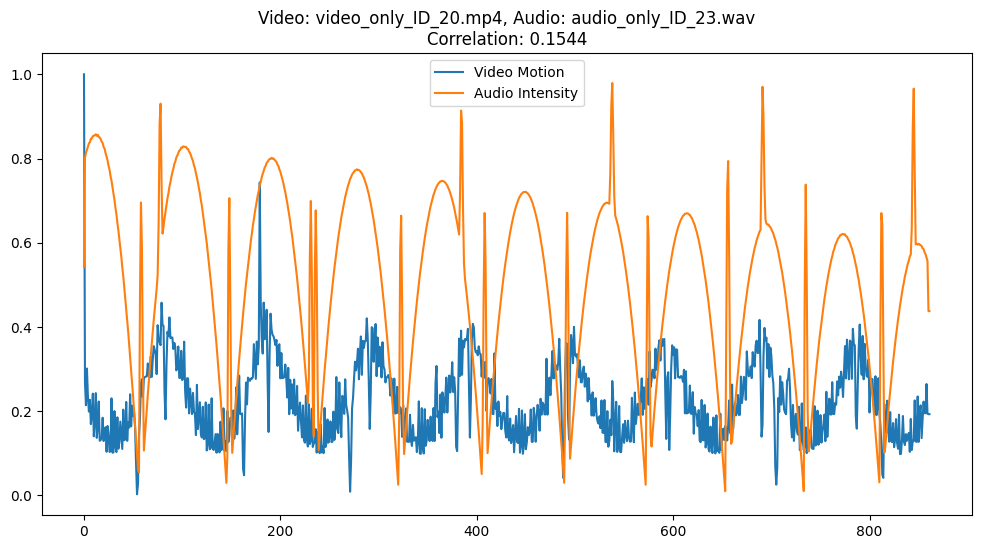

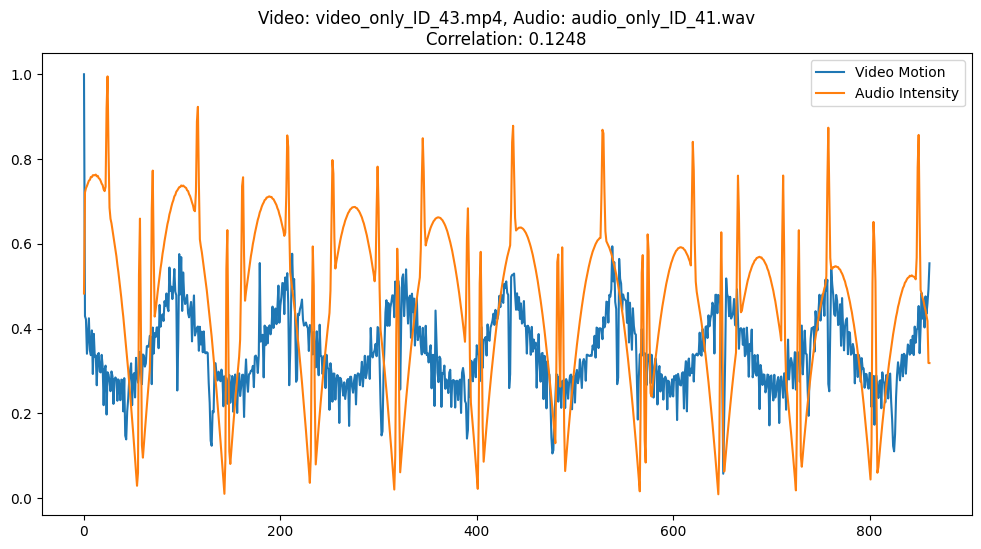

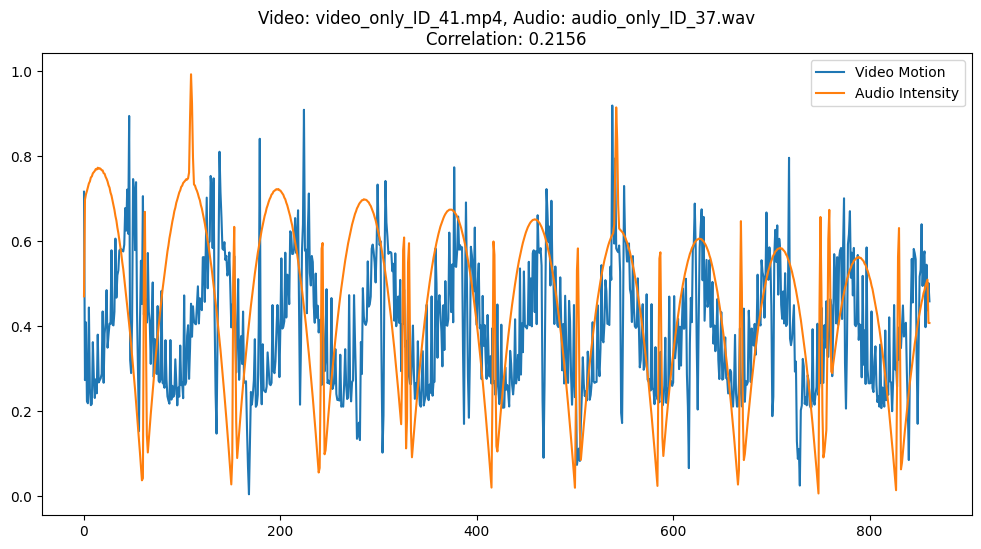


Total matches found: 45


In [11]:
# Execute the main function
if __name__ == "__main__":
    matches_df = generate_matches()
    print("\nValidating a few matches:")
    validate_matches(matches_df)
    print(f"\nTotal matches found: {len(matches_df)}")